In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/146Proj/project

/content/drive/MyDrive/146Proj/project


In [3]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import torch

# My thinking is this:
I dont know how much anatomical variation there is person to person, and how much that would impact our model's prediction capabilities, but it's worth considering that this would be significant. Given this then, perhaps we should explore training different models on individual subjects, and then ensembling these models at the end.

A few things to consider:

1. Is there substantial variation
 - We could explore this intrinsically and look at mean/variance
 - Ultimately though, ensembling is simple enough that it may be worth simply graphing things, and if the hypothesis looks reasonable, implementing some simple ensembling
2. How do we ensemble? We have a variety of choices here, but I want to principally consider:
 - Simply predicting based off of the maximally confident model
 - Simple majority voting
 - Predicting based off of a weighted average of the most confident predictions
 - Stacking, where we train an additional model on top of the ensemble to learn the best combination. We could even just train a simple FC network.
3. It is worth pointing out here that this will likely impact our generalizability, and some routes would impact the time complexity at test time. This is just a tradeoff though, and we should still explore this area. Performance (as compared to non ensembled methods) should ultimately dictate whether or not a less generalizable model is still useful.


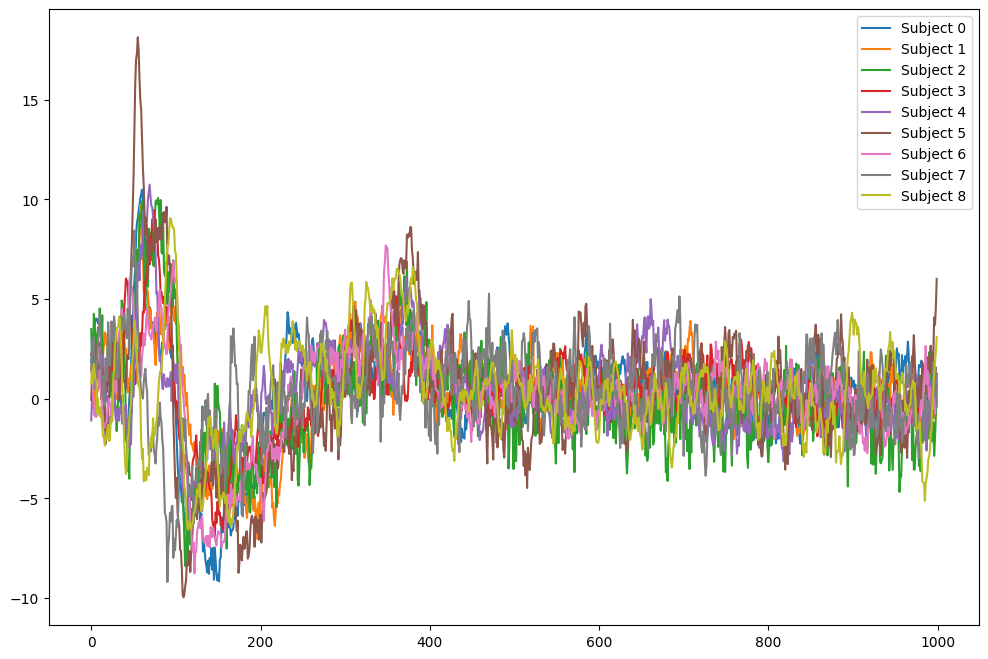

In [30]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

#this is a dataset that has shape (num_samples,1)
person_train_valid = np.load("person_train_valid.npy")
#this is a dataset that has shape (num_samples,num_channels,timesteps)
X_train_valid = np.load("X_train_valid.npy")
#this is a dataset that has shape (num_samples)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

#now, the labels in y_train valid are 0-3 for the different cues, instead of 769-772


#only Visualizing the 8th channel
ch_data = X_train_valid[:,8,:]


#I would like to select those examples where y = 0, and group it so that the subjects are the same across each example, then plot the mean across each example for each subject
#data is of shape (2115,22,1000) = (num_trials,num_channels,num_timesteps)
plt.figure(figsize=(12,8))
axis_array = []
for subjectID,subject in enumerate(np.unique(person_train_valid)):
  subject_string = "Subject "+str(subjectID)
  axis_array.append(subject_string)
  person_train_valid_flat = person_train_valid.flatten()
  class_0_and_subjectID_indices = np.where((y_train_valid == 0) & (person_train_valid_flat == subject))[0]
  avg_per_class_0_and_subjectID = np.mean(ch_data[class_0_and_subjectID_indices],axis=0)
  plt.plot(np.arange(1000),avg_per_class_0_and_subjectID)
plt.legend(axis_array)





#It seems to be pretty messy
This seems supportive of subject-variation, but lets explore fewer subjects to visualize more, and different channels as well.

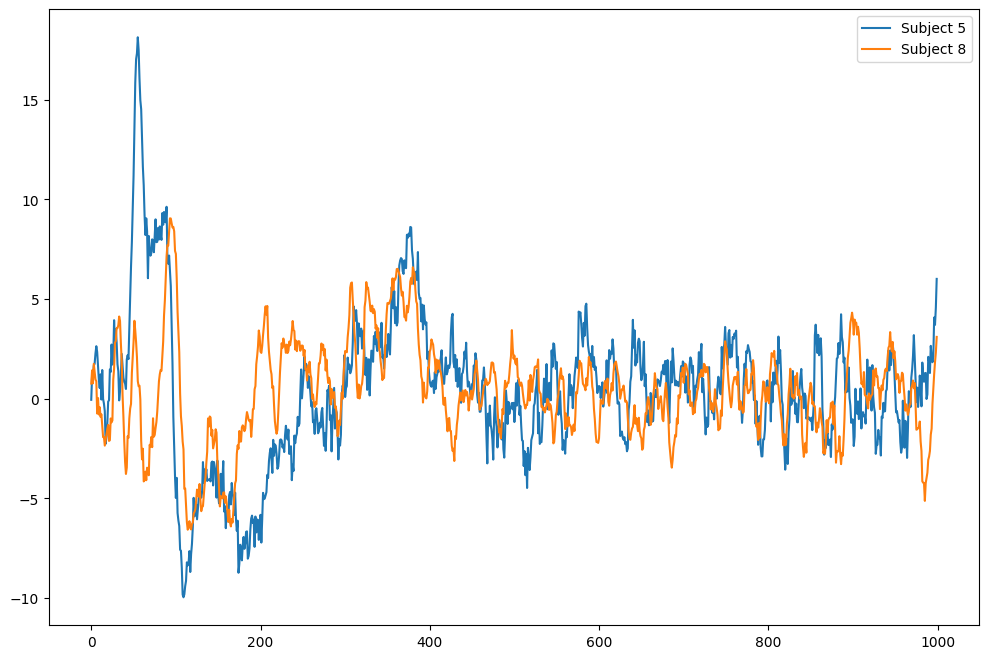

In [34]:
#only Visualizing the 8th channel, but now lets look at just two subjects, 5 and 8 for example
ch_data = X_train_valid[:,8,:]


#I would like to select those examples where y = 0, and group it so that the subjects are the same across each example, then plot the mean across each example for each subject
#data is of shape (2115,22,1000) = (num_trials,num_channels,num_timesteps)
plt.figure(figsize=(12,8))
axis_array = []
for subjectID,subject in enumerate(np.unique(person_train_valid)):
  if subjectID not in (5,8):
    continue
  subject_string = "Subject "+str(subjectID)

  axis_array.append(subject_string)
  person_train_valid_flat = person_train_valid.flatten()
  class_0_and_subjectID_indices = np.where((y_train_valid == 0) & (person_train_valid_flat == subject))[0]
  avg_per_class_0_and_subjectID = np.mean(ch_data[class_0_and_subjectID_indices],axis=0)
  plt.plot(np.arange(1000),avg_per_class_0_and_subjectID)
plt.legend(axis_array)






#Here, we can see some of the challenges we might face in generalizing accross subjects. Looking at the region between the lines below, you can see a totally different input pattern, for the same label. This is still within that 500 bound that seems to hold most of the useful data.

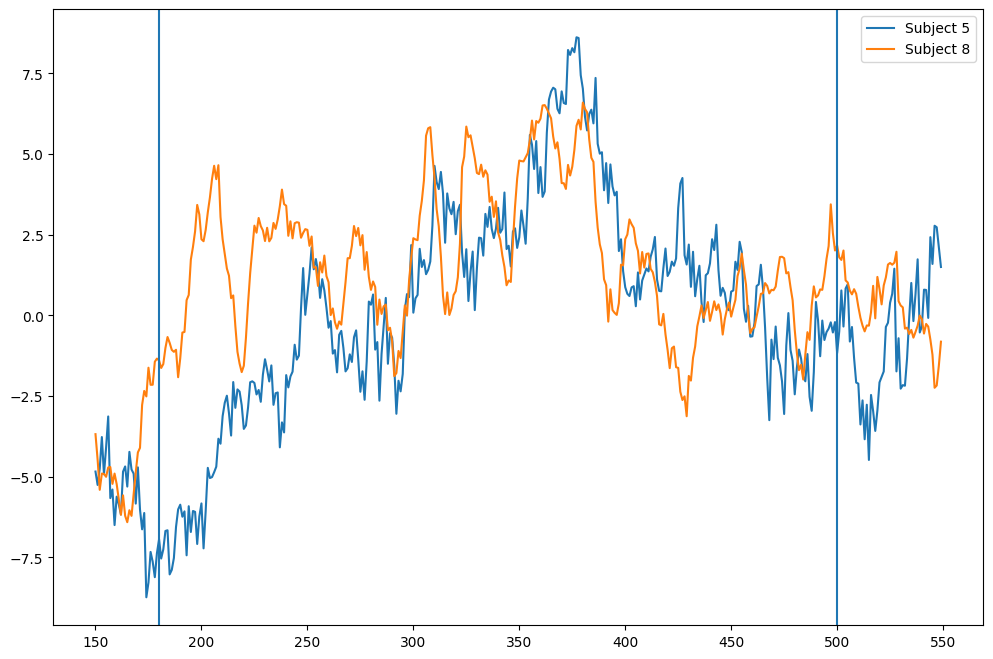

In [39]:
#only Visualizing the 8th channel, but now lets look at just two subjects, 5 and 8 for example
ch_data = X_train_valid[:,8,:]


#I would like to select those examples where y = 0, and group it so that the subjects are the same across each example, then plot the mean across each example for each subject
#data is of shape (2115,22,1000) = (num_trials,num_channels,num_timesteps)
plt.figure(figsize=(12,8))
axis_array = []
for subjectID,subject in enumerate(np.unique(person_train_valid)):
  if subjectID not in (5,8):
    continue
  subject_string = "Subject "+str(subjectID)

  axis_array.append(subject_string)
  person_train_valid_flat = person_train_valid.flatten()
  class_0_and_subjectID_indices = np.where((y_train_valid == 0) & (person_train_valid_flat == subject))[0]
  avg_per_class_0_and_subjectID = np.mean(ch_data[class_0_and_subjectID_indices],axis=0)
  plt.plot(np.arange(150,550),avg_per_class_0_and_subjectID[150:550])
plt.legend(axis_array)
plt.axvline(x=180)
plt.axvline(x=500)

#It is worth pointing out that some channels seem much more similar.

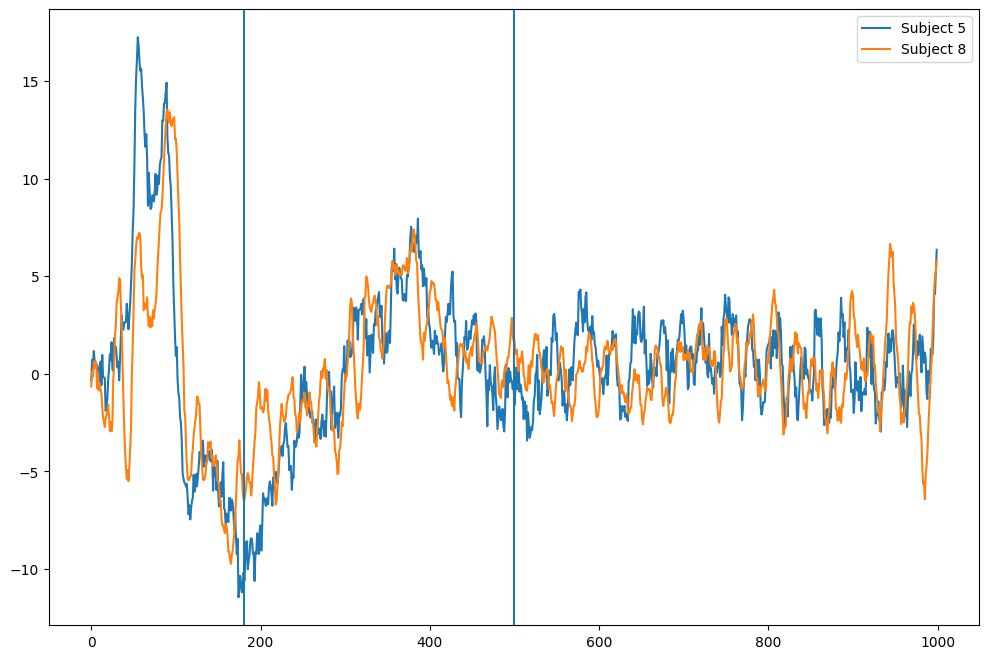

In [46]:
#only Visualizing the 8th channel, but now lets look at just two subjects, 5 and 8 for example
ch_data = X_train_valid[:,16,:]


#I would like to select those examples where y = 0, and group it so that the subjects are the same across each example, then plot the mean across each example for each subject
#data is of shape (2115,22,1000) = (num_trials,num_channels,num_timesteps)
plt.figure(figsize=(12,8))
axis_array = []
for subjectID,subject in enumerate(np.unique(person_train_valid)):
  if subjectID not in (5,8):
    continue
  subject_string = "Subject "+str(subjectID)

  axis_array.append(subject_string)
  person_train_valid_flat = person_train_valid.flatten()
  class_0_and_subjectID_indices = np.where((y_train_valid == 0) & (person_train_valid_flat == subject))[0]
  avg_per_class_0_and_subjectID = np.mean(ch_data[class_0_and_subjectID_indices],axis=0)
  plt.plot(np.arange(1000),avg_per_class_0_and_subjectID)
plt.legend(axis_array)
plt.axvline(x=180)
plt.axvline(x=500)

#Ultimately, I do think this is something reasonable to explore further.

#As a next step, I will train one of the base models across all 9 of the subjects, and will evaluate several simple ensembling mechanisms.